# **Práctica Visión**

- **Autores:** Jose María De Miguel, Miguel Ángel Rojo y Sandra Millán
- **Asignatura:** Visión por Computador
- **Profesores:** D. Luis Baumela y D. Roberto Valle
- **Fecha:** 02/10/25



### **Librerías y carga de datos**

In [ ]:
# Assistant
# Import ImageDataGenerator from tensorflow instead of keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import random
import math
import keras
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

#Numpy
import numpy as np

# The rest of your imports
from keras.models import Sequential, Model
from keras.layers import (
    Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, LeakyReLU,
    Dropout, LayerNormalization, Input, ZeroPadding2D, Activation,
    AveragePooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate,
    RandomTranslation
)
from keras.optimizers import SGD, Adam, RMSprop
from keras.optimizers.schedules import PiecewiseConstantDecay
from keras.initializers import he_normal, VarianceScaling, Orthogonal, GlorotNormal
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

# Métricas sklearn
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    classification_report, precision_recall_fscore_support,
    top_k_accuracy_score, matthews_corrcoef, ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split

# Imagen / procesamiento
from PIL import Image
from skimage.transform import resize
from scipy.ndimage import rotate

# Utilidades
import os
import zipfile  # Added missing import
from typing import Dict, List, Tuple
from tqdm.notebook import tqdm

# Librerías para visualización de datos
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib.image as mpimg

#pandas
import pandas as pd



zip_folder = './'
zip_files = ['xview_recognition.zip']
extract_base_path = './vision_descomprimido'

"""
# DESCOMENTAR PARA DESCOMPRIMIR ZIP
# Extraer cada ZIP
os.makedirs(extract_base_path, exist_ok=True)

for zip_name in zip_files:
    zip_path = os.path.join(zip_folder, zip_name)
    extract_path = os.path.join(extract_base_path, zip_name.replace('.zip', ''))
    os.makedirs(extract_path, exist_ok=True)

    print(f'Extrayendo {zip_name} en {extract_path}...')
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
"""
print("✅ Todo ok.")



### **Carga datos train**





# Ruta principal del dataset
ruta_train = "./vision_descomprimido/xview_recognition/xview_train"

# Obtener todas las clases (carpetas dentro de xview_train)
clases = [nombre for nombre in os.listdir(ruta_train) if os.path.isdir(os.path.join(ruta_train, nombre))]

etiquetas_train = []
file_list = []
num_imagest = []

# Recorremos cada clase
for clase in clases:
    # Ruta de la carpeta de la clase
    folder_path = os.path.join(ruta_train, clase)

    # Lista de archivos en esa carpeta
    aux1 = os.listdir(folder_path)

    # Cantidad de imágenes
    cantidad_img = len(aux1)

    # Etiquetas repetidas según número de imágenes
    aux = [clase] * cantidad_img

    # Guardamos resultados
    num_imagest.append(cantidad_img)
    etiquetas_train += aux
    file_list += aux1

print("Clases encontradas:", clases)
print("Número de imágenes por clase:", num_imagest)
print("Total imágenes:", sum(num_imagest))


# ======================
# Ahora cargamos las imágenes en arrays
# ======================

data_images_train = []

for i in range(len(file_list)):
    # Ruta completa de la imagen
    image_path = os.path.join(ruta_train, etiquetas_train[i], file_list[i])

    # Abrimos y convertimos a array
    image_array = np.array(Image.open(image_path))

    data_images_train.append(image_array)

print("Número total de arrays cargados:", len(data_images_train))

### **Carga datos test**



# Ruta principal del dataset
ruta_test = "/content/vision_descomprimido/xview_recognition/xview_test"

# Obtener todas las clases (carpetas dentro de xview_train)
clases = [nombre for nombre in os.listdir(ruta_test) if os.path.isdir(os.path.join(ruta_test, nombre))]

etiquetas_test = []
file_list = []
num_images = []

# Recorremos cada clase
for clase in clases:
    # Ruta de la carpeta de la clase
    folder_path = os.path.join(ruta_test, clase)

    # Lista de archivos en esa carpeta
    aux1 = os.listdir(folder_path)

    # Cantidad de imágenes
    cantidad_img = len(aux1)

    # Etiquetas repetidas según número de imágenes
    aux = [clase] * cantidad_img

    # Guardamos resultados
    num_images.append(cantidad_img)
    etiquetas_test += aux
    file_list += aux1

print("Clases encontradas:", clases)
print("Número de imágenes por clase:", num_images)
print("Total imágenes:", sum(num_images))


# ======================
# Ahora cargamos las imágenes en arrays
# ======================

data_images_test = []

for i in range(len(file_list)):
    # Ruta completa de la imagen
    image_path = os.path.join(ruta_test, etiquetas_test[i], file_list[i])

    # Abrimos y convertimos a array
    image_array = np.array(Image.open(image_path))

    data_images_test.append(image_array)

print("Número total de arrays cargados:", len(data_images_test))


✅ Todo ok.


### **Distribución clases**

LAS CLASES NO ESTÁN EQUILIBRADAS

Se dibujan dos gráficos diferentes. El primer gráfico permite visualizar qué porcentaje sobre el total de datos representa cada una de las 14 clases.

La segunda figura es un gráfico de barras, siendo el *eje X* el nombre de la clase y el *eje Y* la cantidad de imágenes. Esto nos permite observar la diferencia de tamaños en cada clase así como la clase con mayor o menor representación

### **Mezcla de clases y datos de validación**

- Train: data_images_train - etiquetas_train

- Test:
data_images_test - etiquetas_test


In [ ]:


# Crear DataFrame con las imágenes y sus etiquetas
df = pd.DataFrame({
    'imagen': data_images_train,
    'etiqueta': etiquetas_train
})

# Ordenar por etiqueta
df_sorted = df.sort_values(by='etiqueta').reset_index(drop=True)



imagenes_ordenadas = df_sorted['imagen'].tolist()
etiquetas_ordenadas = df_sorted['etiqueta'].tolist()



# Crear DataFrame con las imágenes y sus etiquetas
df2 = pd.DataFrame({
    'imagen': data_images_test,
    'etiqueta': etiquetas_test
})

# Ordenar por etiqueta
df_sorted2 = df2.sort_values(by='etiqueta').reset_index(drop=True)


data_images_test_ord = df_sorted2['imagen'].tolist()
etiquetas_test_ord = df_sorted2['etiqueta'].tolist()


clases_unicas = np.unique(etiquetas_test_ord)
print("Clases únicas y ordenadas:")
print(clases_unicas)

del df, df_sorted, df2#, df_sorted2

indices = []
etiquetas_unicas = np.unique(etiquetas_ordenadas)
count = 1
plt.figure(figsize=(18, 40))
for etiqueta in etiquetas_unicas:
    # Encuentra el índice de la primera ocurrencia de la etiqueta
    indice = np.where(np.array(etiqueta) == etiquetas_ordenadas)[0][0]
    indices.append(indice)

    # Obtén la imagen correspondiente a la etiqueta
    imagen = imagenes_ordenadas[indice]

    plt.subplot(9, 5, count)
    plt.imshow(imagen)
    plt.title(f'Etiqueta: {etiqueta}')

    count = count + 1

plt.show()

etiquetas = np.array(etiquetas_ordenadas)
indices = [0]  # el primer índice siempre empieza en 0

for i in range(1, len(etiquetas)):
    if etiquetas[i] != etiquetas[i-1]:
        indices.append(i)

print("Indices de cambio de clase:", indices)

nimg = np.array(indices[1:] + [len(etiquetas)]) - np.array(indices)
indices = np.array(indices + [len(etiquetas)])  # cerrar el rango
print("Total de imágenes por clase:", nimg)

nimg = np.round(nimg*0.2)
print(nimg) # 20% del total de imagenes

# Partimos de listas vacías
train_images, train_labels = [], []
validation_images, validation_labels = [], []

# Supongo que:
# - imagenes_ordenadas y etiquetas_ordenadas están alineadas y ordenadas por clase
# - etiquetas_unicas = df_sorted['etiqueta'].unique()
# - indices tiene los inicios de cada clase y un último índice de cierre (len(etiquetas_ordenadas))
# - nimg[i] = round(0.2 * total_imagenes_de_la_clase_i)

for i in range(len(etiquetas_unicas)):
    start = indices[i]
    end   = indices[i+1]           # cierre de la clase i
    k     = int(nimg[i])           # 20% para validación (ya redondeado)

    # --- VALIDACIÓN (20%) ---
    val_imgs = imagenes_ordenadas[start : start + k]
    val_labs = [etiquetas_unicas[i]] * len(val_imgs)
    validation_images += val_imgs
    validation_labels += val_labs   # <- CORREGIDO (antes pisabas con validation_images)

    # --- TRAIN (resto 80%) ---
    tr_imgs = imagenes_ordenadas[start + k : end]
    tr_labs = [etiquetas_unicas[i]] * len(tr_imgs)
    train_images += tr_imgs
    train_labels += tr_labs

# Test viene de fuera (otro split/dataset)
test_images = data_images_test_ord
test_labels = etiquetas_test_ord

# Comprobaciones rápidas
print(f"Train: {len(train_images)} imágenes, {len(train_labels)} etiquetas")
print(f"Val  : {len(validation_images)} imágenes, {len(validation_labels)} etiquetas")
print(f"Test : {len(test_images)} imágenes, {len(test_labels)} etiquetas")


import numpy as np

train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)
test_labels = np.array(test_labels)


print("TAMAÑOS DE LOS CONJUNTOS DE DATOS\n")

print(f"Entrenamiento:")
print(f"  Imágenes: {len(train_images)}")
print(f"  Etiquetas: {len(train_labels)}")
print(f"  Dimensión etiquetas (one-hot): {train_labels.shape}")

print(f"\nValidación:")
print(f"  Imágenes: {len(validation_images)}")
print(f"  Etiquetas: {len(validation_labels)}")
print(f"  Dimensión etiquetas (one-hot): {validation_labels.shape}")

print(f"\nTest:")
print(f"  Imágenes: {len(test_images)}")
print(f"  Etiquetas: {len(test_labels)}")
print(f"  Dimensión etiquetas (one-hot): {test_labels.shape}")


**Codificación**

Las etiquetas proporcionadas anteriormente eran cadenas de caracteres con el nombre del objeto. A continuación, se **codifican** las etiquetas a **representaciones numéricas** para poder trabajar con ellas durante el entrenamiento.

# Se convierten las etiquetas de texto en representaciones numericas
train_labels = LabelEncoder().fit_transform(train_labels)
validation_labels = LabelEncoder().fit_transform(validation_labels)
test_labels = LabelEncoder().fit_transform(test_labels)

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_labels),
                                     y=train_labels)

def aleatorio(train_images, train_labels):
    ale = list(zip(train_images, train_labels))
    np.random.shuffle(ale)
    train_images, train_labels = zip(*ale)
    return np.array(train_images), np.array(train_labels)

train_images, train_labels = aleatorio(train_images, train_labels)
train_labels = to_categorical(train_labels)

validation_images, validation_labels = aleatorio(validation_images, validation_labels)
validation_labels = to_categorical(validation_labels)

test_images, test_labels = aleatorio(test_images, test_labels)
test_labels = to_categorical(test_labels)

In [ ]:
def plot_training_curves(history):

    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

    # sns.despine();

    return





In [ ]:
input_shape = train_images.shape[1:]  # (H, W[, C])

In [ ]:
input_shape

(224, 224, 3)

In [ ]:
# Definimos el modelo
model = Sequential()

# Capa de normalización con la forma de entrada
model.add(BatchNormalization(input_shape=(224, 224, 3)))

# Aplanamos la imagen
model.add(Flatten())

# Capas densas
model.add(Dense(256, activation='elu', kernel_initializer=he_normal()))
model.add(Dropout(0.4))

# Capas densas
model.add(Dense(512, activation='elu', kernel_initializer=he_normal()))
model.add(Dropout(0.4))

model.add(Dense(128, activation='elu', kernel_initializer=he_normal()))
model.add(Dropout(0.3))

# Capa de salida (ajusta num_clases al tamaño de tu problema)
num_clases = train_labels.shape[1]
model.add(Dense(num_clases, activation='softmax'))

# Compilamos el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 224, 224, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,734,361 (147.76 MB)

 Trainable params: 38,734,355 (147.76 MB)

 Non-trainable params: 6 (24.00 B)

In [ ]:
# Entrenamiento del modelo
history = model.fit(
    train_images, train_labels,
    validation_data=(validation_images, validation_labels),
    epochs=100,               # puedes ajustar este número
    batch_size=512,           # tamaño de lote,
    verbose=1
)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - accuracy: 0.1424 - loss: 69.9691 - val_accuracy: 0.1008 - val_loss: 4.7231
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.1306 - loss: 6.4958 - val_accuracy: 0.0547 - val_loss: 3.0057
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.1172 - loss: 3.6746 - val_accuracy: 0.1485 - val_loss: 2.5221
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.1379 - loss: 3.0596 - val_accuracy: 0.1704 - val_loss: 2.3906
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.1432 - loss: 2.8303 - val_accuracy: 0.1779 - val_loss: 2.3404
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.1529 - loss: 2.7186 - val_accuracy: 0.2139 - val_loss: 2.3033
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.1680 - loss: 2.7006 - val_accuracy: 0.2200 - val_loss: 2.2623
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.1689 - loss: 2.6136 - val_accuracy

In [ ]:
def plot_training_curves(history):

    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

    return


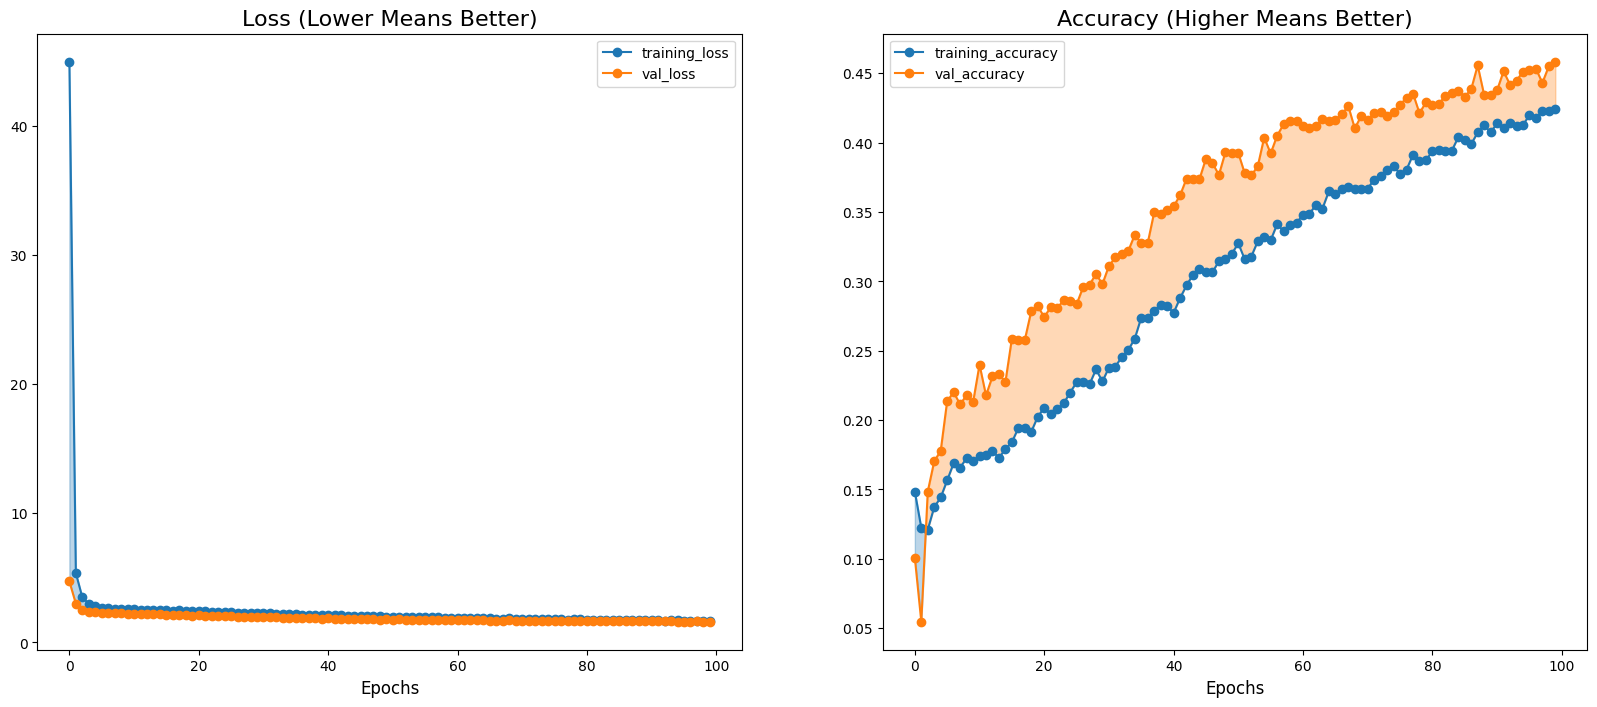

In [ ]:
plot_training_curves(history)

 **Evaluación**

In [ ]:
model.evaluate(test_images, test_labels)

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4030 - loss: 1.7402


[1.7282402515411377, 0.40507400035858154]

### **Predicción**

In [ ]:
predicciones = model.predict(test_images)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [ ]:
def plot_image(i, predictions_array, true_label, img, clases_animales):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == np.argmax(true_label):
        color = 'blue'
    else:
        color = 'red'

    predicted_class = clases_animales[predicted_label]
    true_class = clases_animales[np.argmax(true_label)]

    plt.xlabel("Predicción: {} \n Probabilidad: {:2.0f}% \n Real: {}".format(predicted_class,
                                          100 * np.max(predictions_array),
                                          true_class),
               color=color)


def plot_value_array(i, predictions_array, true_label, clases_animales):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.yticks([])

    thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="#00FF00")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    predicted_class = clases_animales[predicted_label]
    true_class = clases_animales[np.argmax(true_label)]

    thisplot[predicted_label].set_color('red')
    thisplot[np.argmax(true_label)].set_color('black')


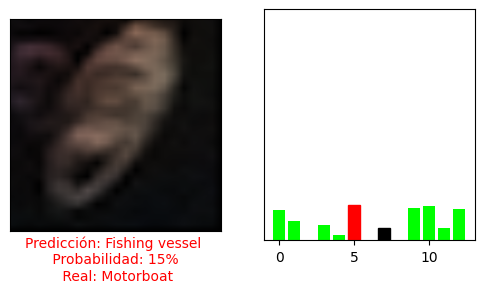

<Figure size 640x480 with 0 Axes>

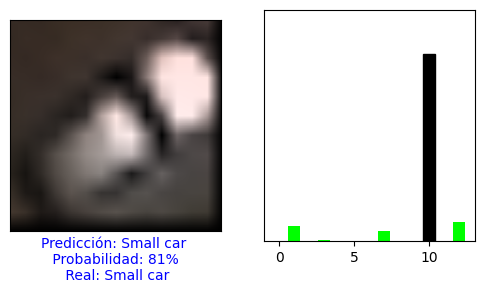

<Figure size 640x480 with 0 Axes>

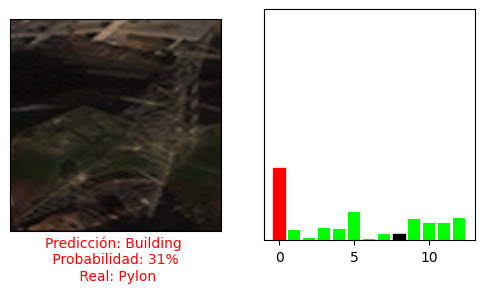

<Figure size 640x480 with 0 Axes>

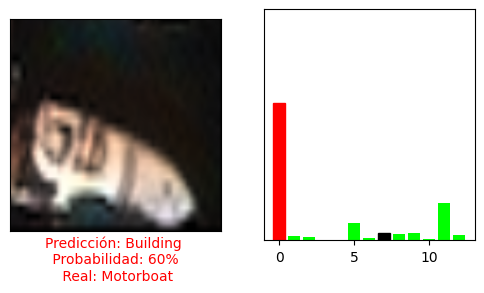

<Figure size 640x480 with 0 Axes>

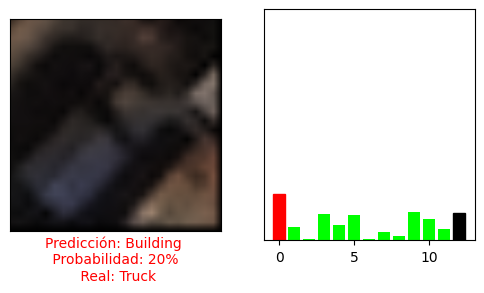

<Figure size 640x480 with 0 Axes>

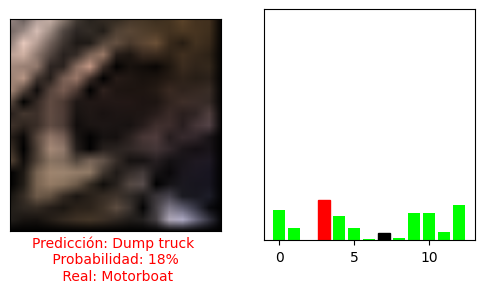

<Figure size 640x480 with 0 Axes>

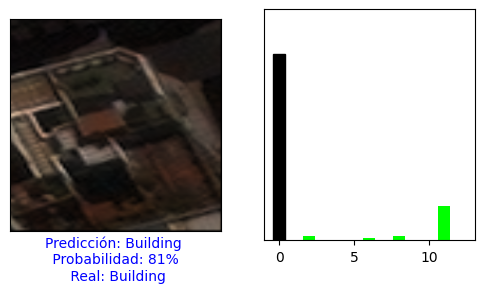

<Figure size 640x480 with 0 Axes>

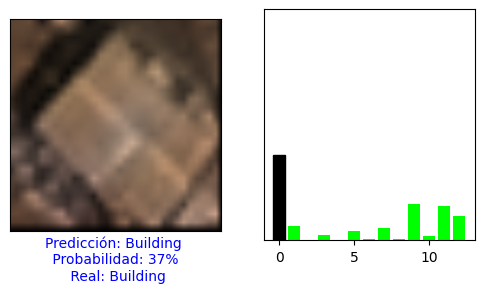

<Figure size 640x480 with 0 Axes>

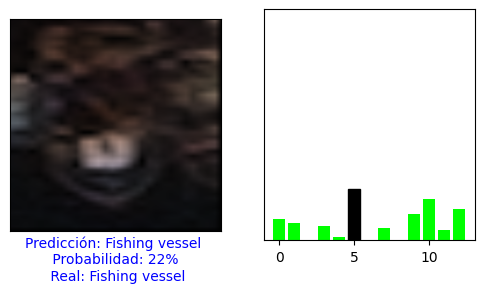

<Figure size 640x480 with 0 Axes>

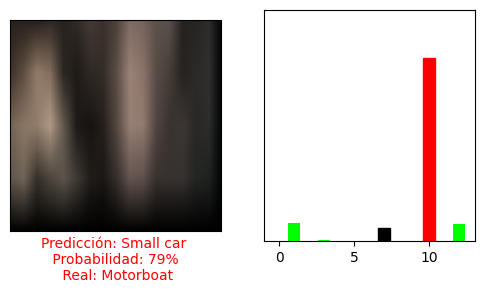

<Figure size 640x480 with 0 Axes>

In [ ]:
for j in range(10):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(j, predicciones[j], test_labels, test_images, clases_unicas)
  plt.subplot(1,2,2)
  plot_value_array(j, predicciones[j],  test_labels, clases_unicas)
  plt.show()
  plt.clf()

### **Matriz de confusión**

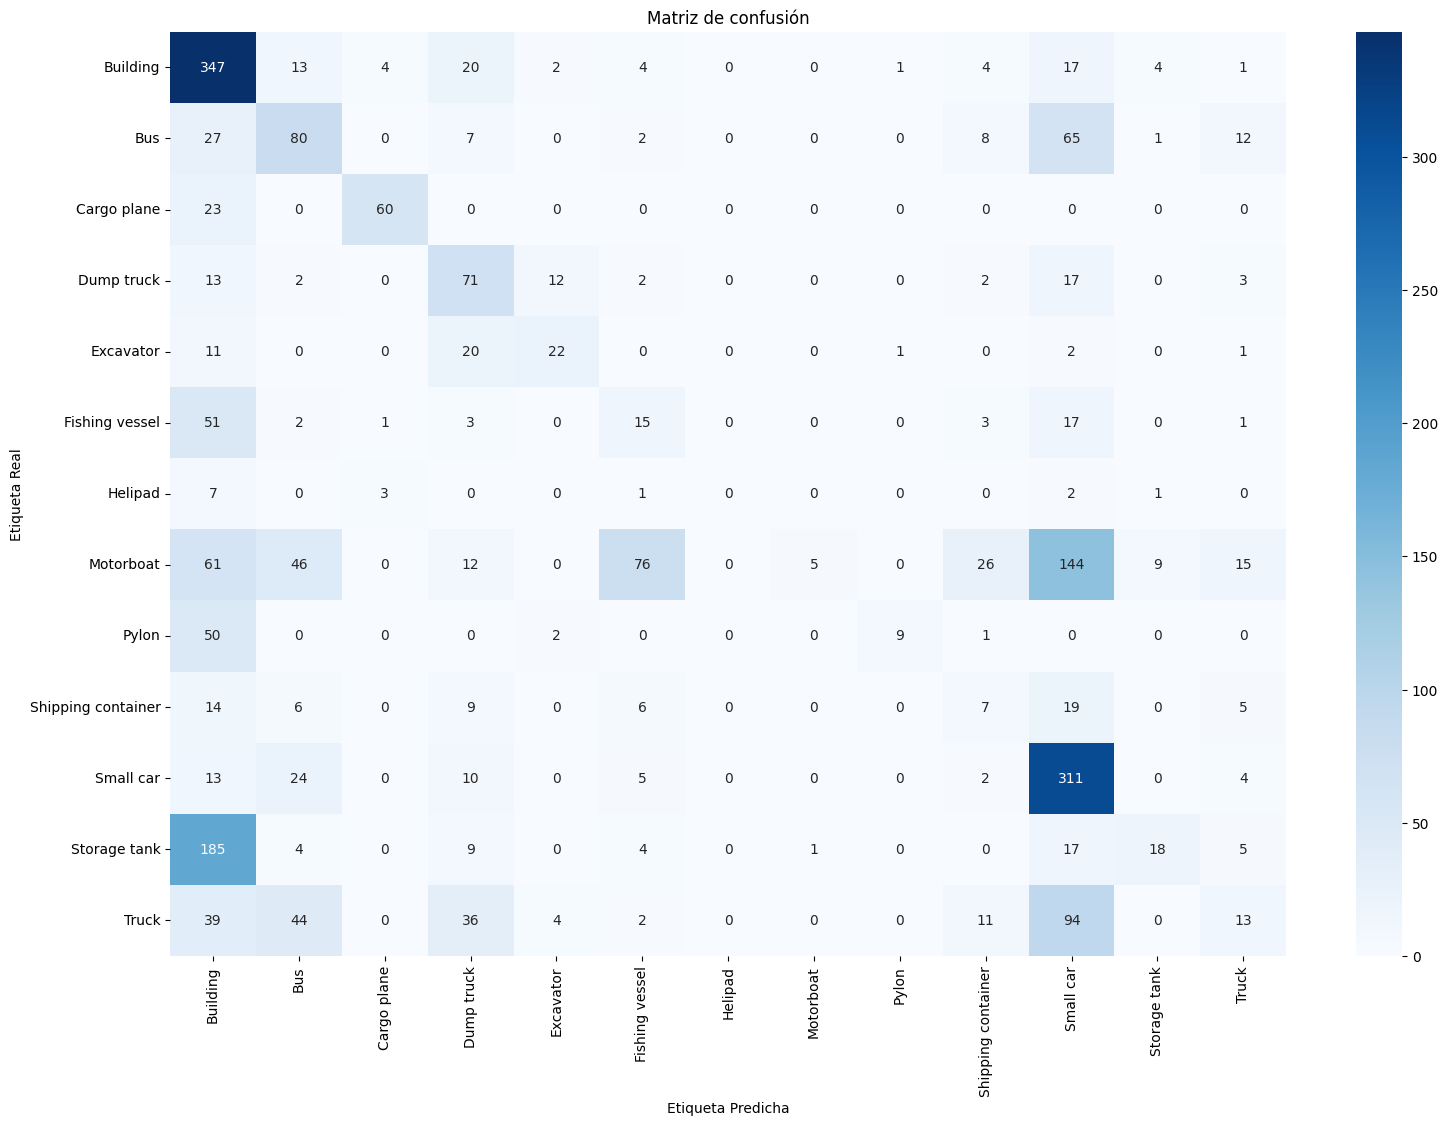

In [ ]:
# Obtener las predicciones en el conjunto de validación
predicciones_labels = np.argmax(predicciones, axis=1)  # Suponiendo que es un problema de clasificación

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predicciones_labels)

# Visualizar la matriz de confusión con seaborn
# Visualizar la matriz de confusión con seaborn y números más pequeños
plt.figure(figsize=(18, 12))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=clases_unicas, yticklabels=clases_unicas,
            annot_kws={"size": 10})  # Ajusta el tamaño de la fuente
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de confusión')
plt.show()

In [ ]:
input_shape = train_images.shape[1:]  # (H, W[, C])

In [ ]:
# Definimos el modelo
model2 = Sequential()

# Capa de normalización con la forma de entrada
model2.add(BatchNormalization(input_shape=(224, 224, 3)))

# Aplanamos la imagen
model2.add(Flatten())

# Capas densas
model2.add(Dense(512, activation='elu', kernel_initializer=he_normal()))
model2.add(Dropout(0.4))

# Capas densas
model2.add(Dense(256, activation='elu', kernel_initializer=he_normal()))
model2.add(Dropout(0.4))

model2.add(Dense(128, activation='elu', kernel_initializer=he_normal()))
model2.add(Dropout(0.4))


model2.add(Dense(64, activation='elu', kernel_initializer=he_normal()))
model2.add(Dropout(0.3))

model2.add(Dense(32, activation='elu', kernel_initializer=he_normal()))
model2.add(Dropout(0.35))

model2.add(Dense(16, activation='elu', kernel_initializer=he_normal()))
model2.add(Dropout(0.2))

# Capa de salida (ajusta num_clases al tamaño de tu problema)
num_clases = train_labels.shape[1]
model2.add(Dense(num_clases, activation='softmax'))

# Compilamos el modelo
model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 224, 224, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,246,169 (294.67 MB)

 Trainable params: 77,246,163 (294.67 MB)

 Non-trainable params: 6 (24.00 B)

In [ ]:
# Entrenamiento del modelo
history2 = model2.fit(
    train_images, train_labels,
    validation_data=(validation_images, validation_labels),
    epochs=100,               # puedes ajustar este número
    batch_size=512,           # tamaño de lote,
    verbose=1
)

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.0854 - loss: 60.1256 - val_accuracy: 0.1917 - val_loss: 2.4910
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1491 - loss: 3.6017 - val_accuracy: 0.1917 - val_loss: 2.3544
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1737 - loss: 2.7515 - val_accuracy: 0.1917 - val_loss: 2.3218
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1761 - loss: 2.5410 - val_accuracy: 0.1917 - val_loss: 2.3160
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.1768 - loss: 2.4488 - val_accuracy: 0.1917 - val_loss: 2.3147
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1825 - loss: 2.4280 - val_accuracy: 0.1917 - val_loss: 2.3144
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1715 - loss: 2.4319 - val_accuracy: 0.1917 - val_loss: 2.3141
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1804 - loss: 

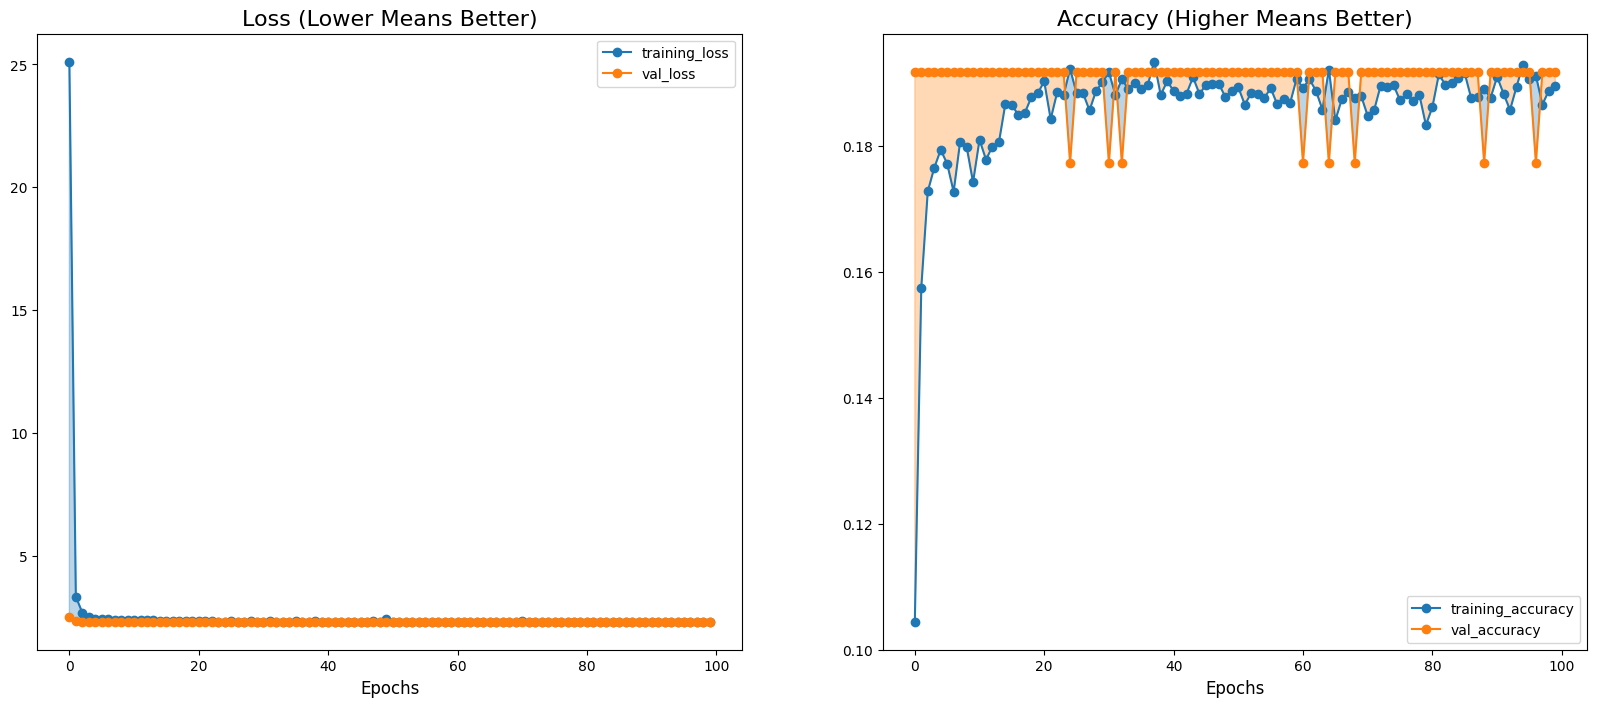

In [ ]:
plot_training_curves(history2)

En una tercera fase de mejora del modelo, se implementan técnicas avanzadas destinadas a optimizar su rendimiento. Entre ellas se incluyen la técnica 'data augmentation', la variación dinámica de la tasa de aprendizaje durante el entrenamiento en función de la exactitud sobre el conjunto de validación, la incorporación de capas adicionales de normalización por lotes, la experimentación con distintos optimizadores, la asignación de pesos de clase para abordar el desbalance de datos y la evaluación del impacto de diferentes tamaños de lote (batch size).

En primer lugar, partiendo del modelo base (el primer modelo), se añaden capas 'BatchNormalization()' después de cada capa densa. Además, se introduce la variación dinámica de la tasa de aprendizaje durante el entrenamiento en función de la exactitud sobre el conjunto de validación. Con una paciencia (épocas que espera a variar el learning rate si no se mejora según el criterio), se irá multiplicando el lr por un factor para reducirlo. También se incluye la asignación de pesos a los datos según su clase, para afrontar el problema del desbalanceo de los datos.

In [ ]:
input_shape = train_images.shape[1:]  # (H, W[, C])

In [ ]:
# Definimos el modelo
model = Sequential()

# Capa de normalización con la forma de entrada
model.add(BatchNormalization(input_shape=input_shape))

# Aplanamos la imagen
model.add(Flatten())

# Capas densas
model.add(Dense(256, activation='elu', kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Capas densas
model.add(Dense(512, activation='elu', kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128, activation='elu', kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Capa de salida (ajusta num_clases al tamaño de tu problema)
num_clases = train_labels.shape[1]
model.add(Dense(num_clases, activation='softmax'))

# Compilamos el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 224, 224, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,737,945 (147.77 MB)

 Trainable params: 38,736,147 (147.77 MB)

 Non-trainable params: 1,798 (7.02 KB)

In [ ]:
# Configuración de la Callback ReduceLROnPlateau:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.75,
                              patience=10,
                              min_lr=1e-4)

# Entrenamiento del modelo
history = model.fit(
    train_images, train_labels,
    validation_data=(validation_images, validation_labels),
    epochs=100,               # puedes ajustar este número
    batch_size=512,           # tamaño de lote,
    verbose=1,
    callbacks=[reduce_lr],
    class_weight=dict(enumerate(class_weights))
)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 321ms/step - accuracy: 0.1252 - loss: 3.0122 - val_accuracy: 0.1541 - val_loss: 12.3091 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.1946 - loss: 2.4059 - val_accuracy: 0.2021 - val_loss: 4.1832 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.2335 - loss: 2.1452 - val_accuracy: 0.2589 - val_loss: 2.7168 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.2680 - loss: 2.0326 - val_accuracy: 0.3027 - val_loss: 2.2777 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.2914 - loss: 1.9616 - val_accuracy: 0.3323 - val_loss: 2.0452 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.3059 - loss: 1.8807 - val_accuracy: 0.3829 - val_loss: 1.9051 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.3250 - loss: 1.799

In [ ]:
model.save_weights("modelo3_1.weights.h5")

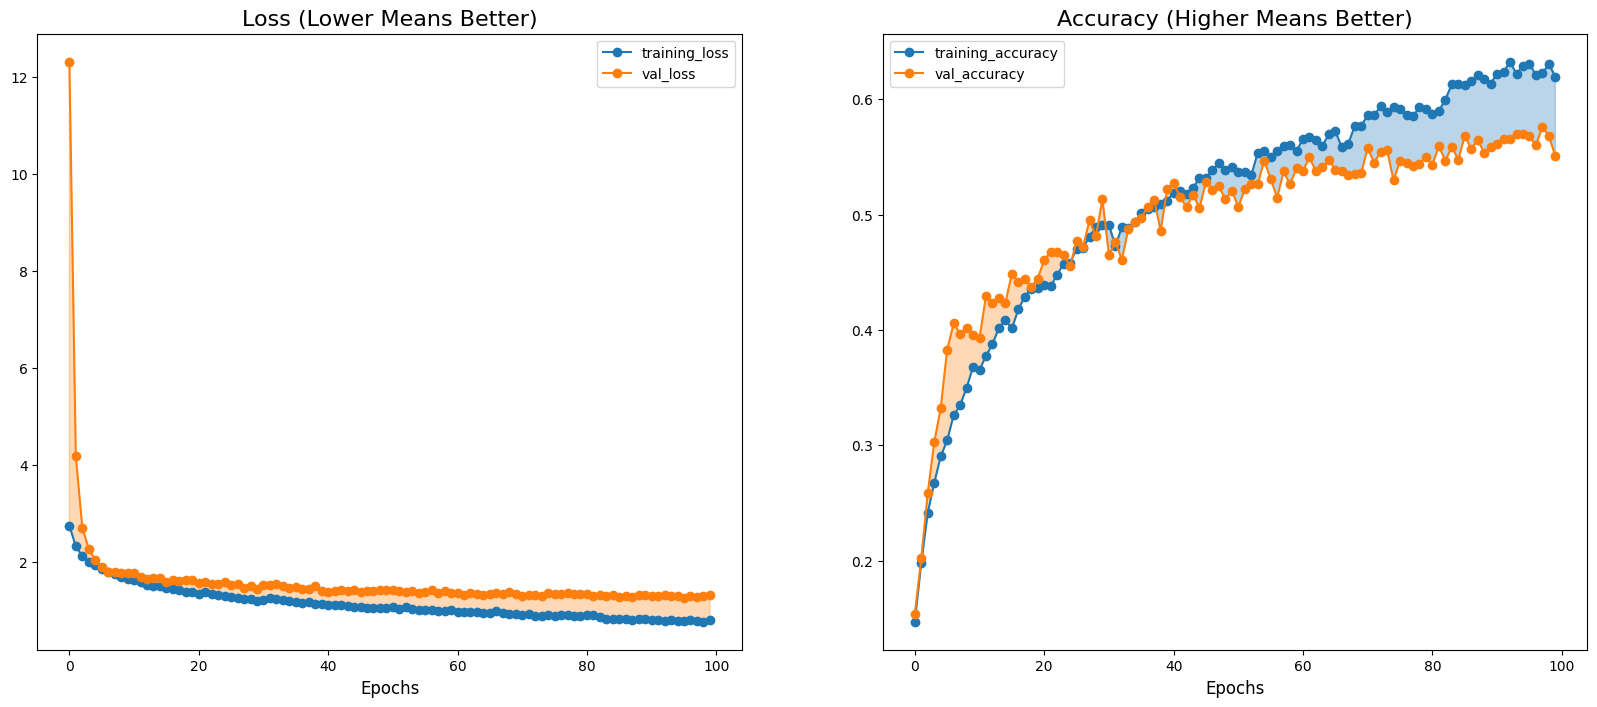

In [ ]:
plot_training_curves(history)

In [ ]:
model.evaluate(test_images, test_labels)

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5114 - loss: 1.4398


[1.4701001644134521, 0.5057082176208496]

In [ ]:
from tensorflow import keras

model.load_weights("/content/modelo3_1.weights.h5")

model.evaluate(test_images, test_labels)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 



74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5057 - loss: 1.4712


[1.5004278421401978, 0.5061310529708862]

Ahora, se prueba el mismo modelo, con el optimizador RMSprop y con un batch size de 256

In [ ]:
# Definimos el modelo
model = Sequential()

# Capa de normalización con la forma de entrada
model.add(BatchNormalization(input_shape=input_shape))

# Aplanamos la imagen
model.add(Flatten())

# Capas densas
model.add(Dense(256, activation='elu', kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Capas densas
model.add(Dense(512, activation='elu', kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128, activation='elu', kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Capa de salida (ajusta num_clases al tamaño de tu problema)
num_clases = train_labels.shape[1]
model.add(Dense(num_clases, activation='softmax'))

learning_rate = 0.001
rho = 0.9
momentum = 0.7
epsilon = 1e-07
decay = 0.0

# Crear el optimizador RMSprop con momentum
optimizador = RMSprop(learning_rate=learning_rate,
         rho=rho, momentum=momentum,
         epsilon=epsilon, decay=decay)

# Compilamos el modelo
model.compile(
    optimizer=optimizador,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_12          │ (None, 224, 224, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,737,945 (147.77 MB)

 Trainable params: 38,736,147 (147.77 MB)

 Non-trainable params: 1,798 (7.02 KB)

In [ ]:
# Configuración de la Callback ReduceLROnPlateau:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.75,
                              patience=10,
                              min_lr=1e-4)

# Callback: guardar el mejor modelo según val_accuracy
guardar_mejor = ModelCheckpoint(
    filepath='mejor_modelo_3_2.keras',       # archivo donde se guardará el mejor
    monitor='val_accuracy',              # métrica a observar
    save_best_only=True,                 # solo guarda si mejora
    mode='max',                          # queremos maximizar accuracy
    verbose=0
)

# Entrenamiento del modelo
history = model.fit(
    train_images, train_labels,
    validation_data=(validation_images, validation_labels),
    epochs=100,               # puedes ajustar este número
    batch_size=256,           # tamaño de lote,
    verbose=1,
    callbacks=[reduce_lr, guardar_mejor],
    class_weight=dict(enumerate(class_weights))
)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 27s 288ms/step - accuracy: 0.1552 - loss: 2.7228 - val_accuracy: 0.1701 - val_loss: 6.7803 - learning_rate: 0.0010
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 16s 281ms/step - accuracy: 0.2540 - loss: 2.0630 - val_accuracy: 0.2965 - val_loss: 2.2677 - learning_rate: 0.0010
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 51s 870ms/step - accuracy: 0.3032 - loss: 1.8450 - val_accuracy: 0.3728 - val_loss: 1.9579 - learning_rate: 0.0010
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.3344 - loss: 1.7355 - val_accuracy: 0.3867 - val_loss: 1.7983 - learning_rate: 0.0010
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.3614 - loss: 1.6811 - val_accuracy: 0.4096 - val_loss: 1.7210 - learning_rate: 0.0010
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3613 - loss: 1.6306 - val_accuracy: 0.4091 - val_loss: 1.7290 - learning_rate: 0.0010
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.3796 - loss: 1.5852

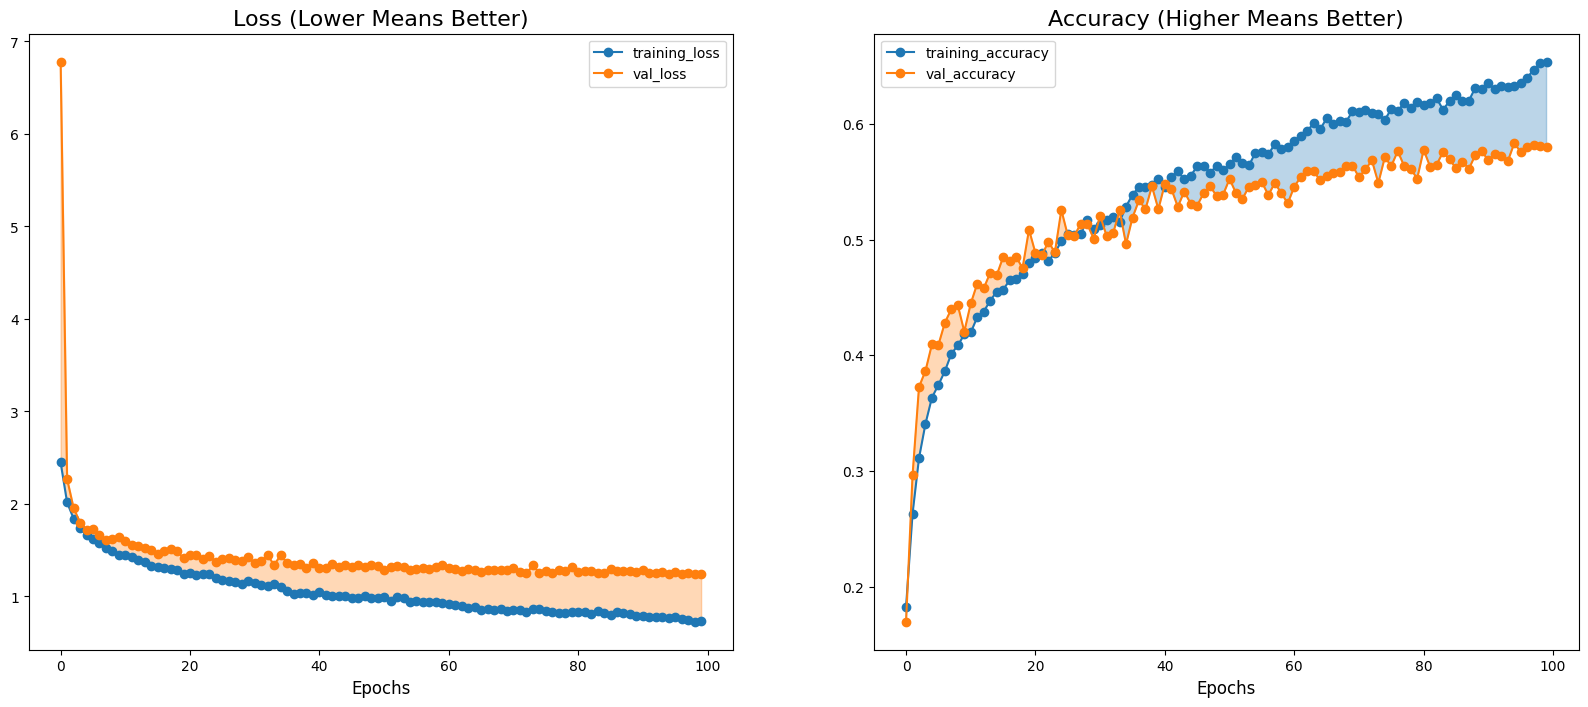

In [ ]:
plot_training_curves(history)

In [ ]:
from tensorflow import keras
model = keras.models.load_model("/content/mejor_modelo_3_2.keras")

In [ ]:
model.evaluate(test_images, test_labels)

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5176 - loss: 1.4340


[1.4662806987762451, 0.5120507478713989]

Se consigue mejorar ligeramente el rendimiento en los datos de prueba.

Se prueba otra vez con el optimizador Adam y añadiendole data augmentation durante el entrenamiento.

In [ ]:
# Definimos el modelo
model = Sequential()

# Capa de normalización con la forma de entrada
model.add(BatchNormalization(input_shape=input_shape))

model.add(RandomTranslation(height_factor=0.2, width_factor=0.2, seed=None, name='random_translation'))

# Aplanamos la imagen
model.add(Flatten())

# Capas densas
model.add(Dense(256, activation='elu', kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Capas densas
model.add(Dense(512, activation='elu', kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128, activation='elu', kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Capa de salida (ajusta num_clases al tamaño de tu problema)
num_clases = train_labels.shape[1]
model.add(Dense(num_clases, activation='softmax'))

# Compilamos el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_20          │ (None, 224, 224, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,737,945 (147.77 MB)

 Trainable params: 38,736,147 (147.77 MB)

 Non-trainable params: 1,798 (7.02 KB)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.75,
    patience=20,
    min_lr=1e-4,
    verbose=1
)

history = model.fit(
    train_images, train_labels,
    validation_data=(validation_images, validation_labels),
    epochs=300,
    batch_size=64,
    verbose=1,
    callbacks=[reduce_lr],#, guardar_mejor],
    class_weight=dict(enumerate(class_weights))
)

Epoch 1/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.1142 - loss: 2.9042 - val_accuracy: 0.1824 - val_loss: 2.4614 - learning_rate: 0.0010
Epoch 2/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.1511 - loss: 2.3978 - val_accuracy: 0.2085 - val_loss: 2.2667 - learning_rate: 0.0010
Epoch 3/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.1665 - loss: 2.3212 - val_accuracy: 0.2280 - val_loss: 2.1830 - learning_rate: 0.0010
Epoch 4/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.1810 - loss: 2.2095 - val_accuracy: 0.2523 - val_loss: 2.1348 - learning_rate: 0.0010
Epoch 5/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.2003 - loss: 2.1463 - val_accuracy: 0.2624 - val_loss: 2.1136 - learning_rate: 0.0010
Epoch 6/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.2167 - loss: 2.1055 - val_accuracy: 0.2667 - val_loss: 2.0772 - learning_rate: 0.0010
Epoch 7/300
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.21

In [ ]:
model.save_weights("modelo3_3.weights.h5")

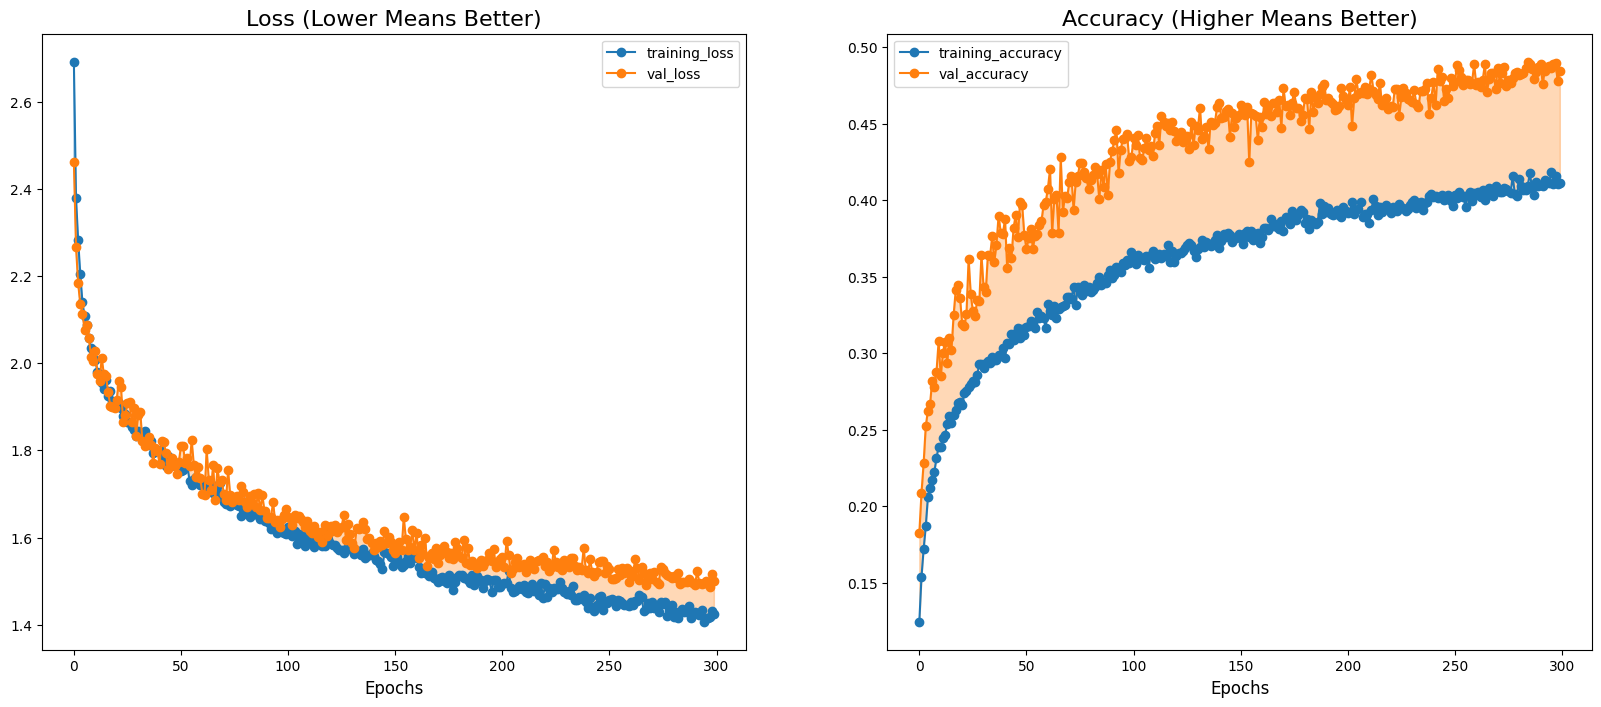

In [ ]:
plot_training_curves(history)

In [ ]:
model.evaluate(test_images, test_labels)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4297 - loss: 1.6238


[1.6151615381240845, 0.43171247839927673]

Con el data augmentation no converge, no aprende de los datos, quizas habría que bajarle el dropout para que si que ayudase el data augmentation, pero no hay tiempo, probamos con un modelo con RMSprop y menos batch size que antes.

In [ ]:
# Definimos el modelo
model = Sequential()

# Capa de normalización con la forma de entrada
model.add(BatchNormalization(input_shape=input_shape))

# Aplanamos la imagen
model.add(Flatten())

# Capas densas
model.add(Dense(256, activation='elu', kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Capas densas
model.add(Dense(512, activation='elu', kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128, activation='elu', kernel_initializer=he_normal()))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Capa de salida (ajusta num_clases al tamaño de tu problema)
num_clases = train_labels.shape[1]
model.add(Dense(num_clases, activation='softmax'))

learning_rate = 0.001
rho = 0.9
momentum = 0.7
epsilon = 1e-07
decay = 0.0

# Crear el optimizador RMSprop con momentum
optimizador = RMSprop(learning_rate=learning_rate,
         rho=rho, momentum=momentum,
         epsilon=epsilon, decay=decay)

# Compilamos el modelo
model.compile(
    optimizer=optimizador,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_24          │ (None, 224, 224, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,737,945 (147.77 MB)

 Trainable params: 38,736,147 (147.77 MB)

 Non-trainable params: 1,798 (7.02 KB)

In [ ]:
# Configuración de la Callback ReduceLROnPlateau:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.75,
                              patience=10,
                              min_lr=1e-4)

# Entrenamiento del modelo
history = model.fit(
    train_images, train_labels,
    validation_data=(validation_images, validation_labels),
    epochs=100,               # puedes ajustar este número
    batch_size=64,           # tamaño de lote,
    verbose=1,
    callbacks=[reduce_lr],
    class_weight=dict(enumerate(class_weights))
)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.1628 - loss: 2.5819 - val_accuracy: 0.3112 - val_loss: 1.9945 - learning_rate: 0.0010
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2718 - loss: 1.9355 - val_accuracy: 0.3357 - val_loss: 1.8573 - learning_rate: 0.0010
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.3234 - loss: 1.7777 - val_accuracy: 0.3880 - val_loss: 1.7496 - learning_rate: 0.0010
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3496 - loss: 1.7261 - val_accuracy: 0.3808 - val_loss: 1.7635 - learning_rate: 0.0010
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3638 - loss: 1.6775 - val_accuracy: 0.4296 - val_loss: 1.6508 - learning_rate: 0.0010
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.3802 - loss: 1.6053 - val_accuracy: 0.4245 - val_loss: 1.6255 - learning_rate: 0.0010
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3950 - 

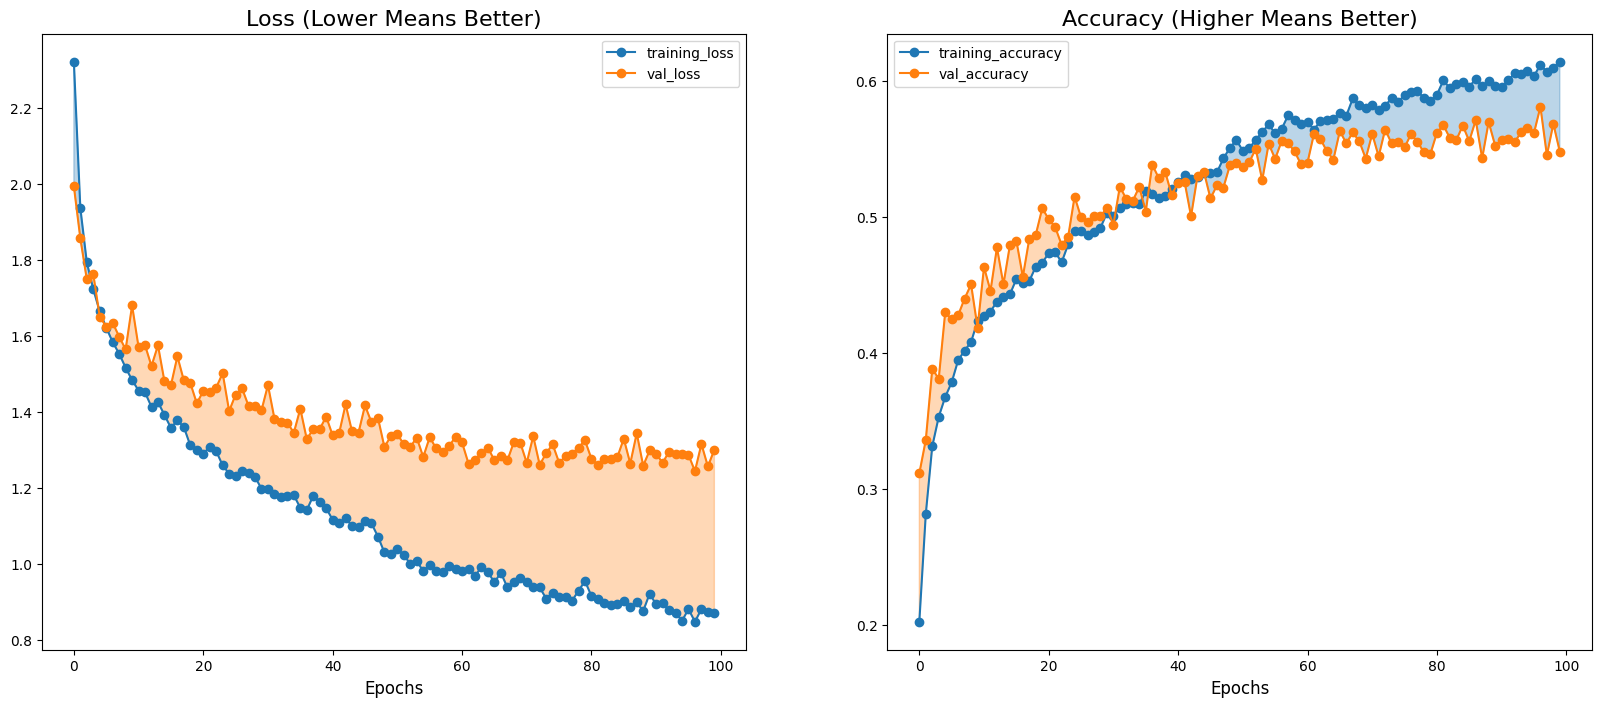

In [ ]:
plot_training_curves(history)

In [ ]:
model.evaluate(test_images, test_labels)

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4811 - loss: 1.5353


[1.5241551399230957, 0.4769555926322937]

# **CNNs**

In [ ]:
from tensorflow.keras import layers, models

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.1),
])



NUM_CLASSES = 13
BATCH_SIZE = 64
input_shape=(224,224,3)

inputs = layers.Input(shape=input_shape)

x = data_augmentation(inputs)

# Bloque 1
x = layers.Conv2D(32, (3,3), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(32, (3,3), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

# Bloque 2
x = layers.Conv2D(64, (3,3), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(64, (3,3), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

# Bloque 3
x = layers.Conv2D(128, (3,3), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Conv2D(128, (3,3), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.4)(x)

# Bloque 4tras
x = layers.Conv2D(256, (3,3), padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.4)(x)

# Cabeza
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.summary()



In [2]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,               # <- aquí va la paciencia
    restore_best_weights=True,

)


history = model.fit(
    train_images, train_labels,
    validation_data=(validation_images, validation_labels),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=dict(enumerate(class_weights))
)

NameError: name 'model' is not defined

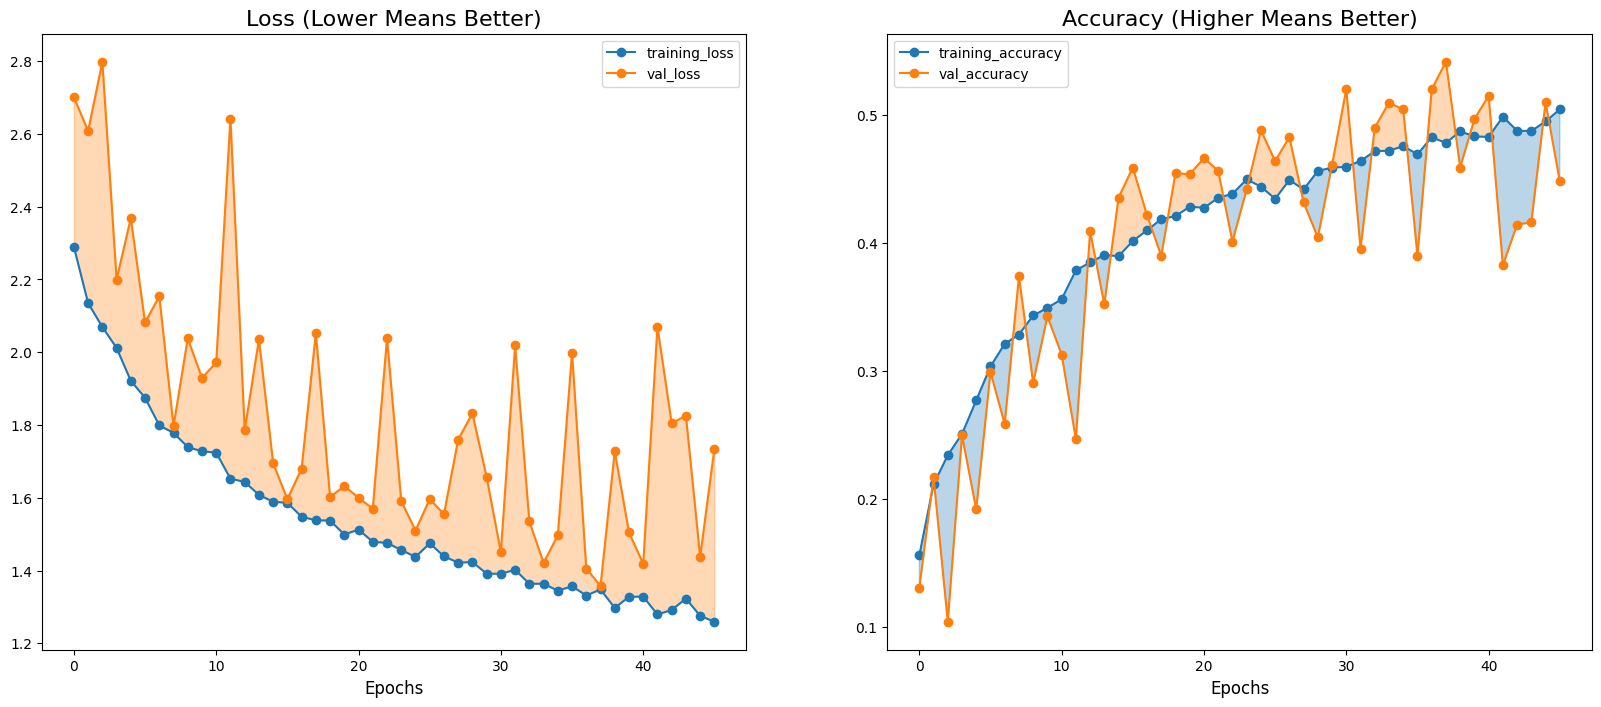

# **JSON** - el modelo se tiene que llamar model

In [ ]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

anns = []
for (dirpath, dirnames, filenames) in os.walk(ruta_test):
    for filename in filenames:
        image = GenericImage(dirpath[29:] + '/' + filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

import numpy as np
from tensorflow.keras.preprocessing import image as keras_image

categories = {0: 'Building', 1: 'Bus', 2: 'Cargo plane', 3: 'Dump truck', 4: 'Excavator', 5: 'Fishing vessel',
6: 'Helipad', 7: 'Motorboat', 8: 'Pylon', 9: 'Shipping container', 10: 'Small car',
11: 'Storage tank', 12: 'Truck'}

predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load
    fixed_path = "/content/vision_descomprimido" + ann.filename
    image = keras_image.load_img(fixed_path)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)

with open("prediction_bonito.json", "w") as outfile:
    json.dump(predictions_data, outfile, indent=1)